## Define Area of Interest (AOI)

Use the map below to draw a rectangle defining your processing area. The maximum size is approximately 600x600 pixels at 10m resolution.

In [3]:
import openeo
from extractor import load_input_WAC
from inference import inference_WAC


CRS = "EPSG:3035"
RESOLUTION = 10  # important; the resolution is implicitely tied to the CRS; so we need to use UTM based CRS here
PATCH_SIZE = 64
OVERLAP_SIZE = 16

SPATIAL_EXTENT = {
    'west': 300000,
    'south': 9800000,
    'east': 305000,  
    'north': 9805000,  
    'crs': CRS  
}

N_CLASSES = 21

TEMPORAL_EXTENT = ['2023-06-01', '2023-08-01'] 
MAX_CLOUD_COVER = 85


JOB_OPTIONS = {'driver-memory': '2000m',
 'driver-memoryOverhead': '2000m',
 'executor-memory': '3000m',
 'executor-memoryOverhead': '3000m',
 'python-memory': '8000m',
 'max-executors': 20,
 "udf-dependency-archives": [
        "https://s3.waw3-1.cloudferro.com/swift/v1/project_dependencies/onnx_dependencies_1.16.3.zip#onnx_deps",
        "https://s3.waw3-1.cloudferro.com/swift/v1/project_dependencies/FusionUNet_OilpalmModel_20250718131837.zip#onnx_models"
        ]
 }


In [2]:
connection = openeo.connect("https://openeo.dataspace.copernicus.eu/")
connection.authenticate_oidc()

new_band_names = ['mask_weights'] + [f"prob_class_{c}" for c in range(N_CLASSES)]
input_cube = load_input_WAC(connection, SPATIAL_EXTENT, TEMPORAL_EXTENT, MAX_CLOUD_COVER, RESOLUTION, CRS)
#inference_cube = inference_WAC(input_cube, patch_size=PATCH_SIZE, overlap = OVERLAP_SIZE)
#ROI_inference_cube =ROI_inference_cube.rename_labels(dimension = 'bands', target = new_band_names)


input_cube = input_cube.save_result(format = "netCDF")


job = connection.create_job(input_cube,
    additional=JOB_OPTIONS
)

job.start_and_wait()



Authenticated using refresh token.


ValueError: Invalid dimension 'bands'. Should be one of ['t', 'x', 'y']

In [30]:
OUTPUT_DIR = "C:/Git_projects/WAC/production/prediction/input_test" + job.job_id
OUTPUT_FILE_ROI = f"{OUTPUT_DIR}"
job.get_results().download_files(OUTPUT_FILE_ROI)


[WindowsPath('C:/Git_projects/WAC/production/prediction/input_testj-2507181257094f7ea5fc7e7f8cb7770a/openEO_2023-06-01Z.tif'),
 WindowsPath('C:/Git_projects/WAC/production/prediction/input_testj-2507181257094f7ea5fc7e7f8cb7770a/openEO_2023-07-01Z.tif'),
 WindowsPath('C:/Git_projects/WAC/production/prediction/input_testj-2507181257094f7ea5fc7e7f8cb7770a/job-results.json')]

Number of bands: 17
Band 1: min = 0.0040288809686899185, max = 0.9942620396614075
Band 2: min = 0.01014928799122572, max = 0.9943005442619324
Band 3: min = 0.011712643317878246, max = 0.9928817749023438
Band 4: min = 0.007972457446157932, max = 0.9155128598213196
Band 5: min = 0.003713145386427641, max = 0.9940077662467957
Band 6: min = 0.0026406957767903805, max = 0.9940553307533264
Band 7: min = 0.0022403562907129526, max = 0.9943027496337891
Band 8: min = 0.009065856225788593, max = 0.9941299557685852
Band 9: min = 0.007819024845957756, max = 0.9923622608184814
Band 10: min = 0.0, max = 0.9726603627204895
Band 11: min = 0.0, max = 0.8860092163085938
Band 12: min = 0.0, max = 1.0
Band 13: min = 0.029803162440657616, max = 1.0
Band 14: min = 0.0, max = 1.0
Band 15: min = 0.04761580377817154, max = 0.09269282966852188
Band 16: min = 0.15551501512527466, max = 0.15572361648082733
Band 17: min = 0.8828858733177185, max = 0.8829346895217896


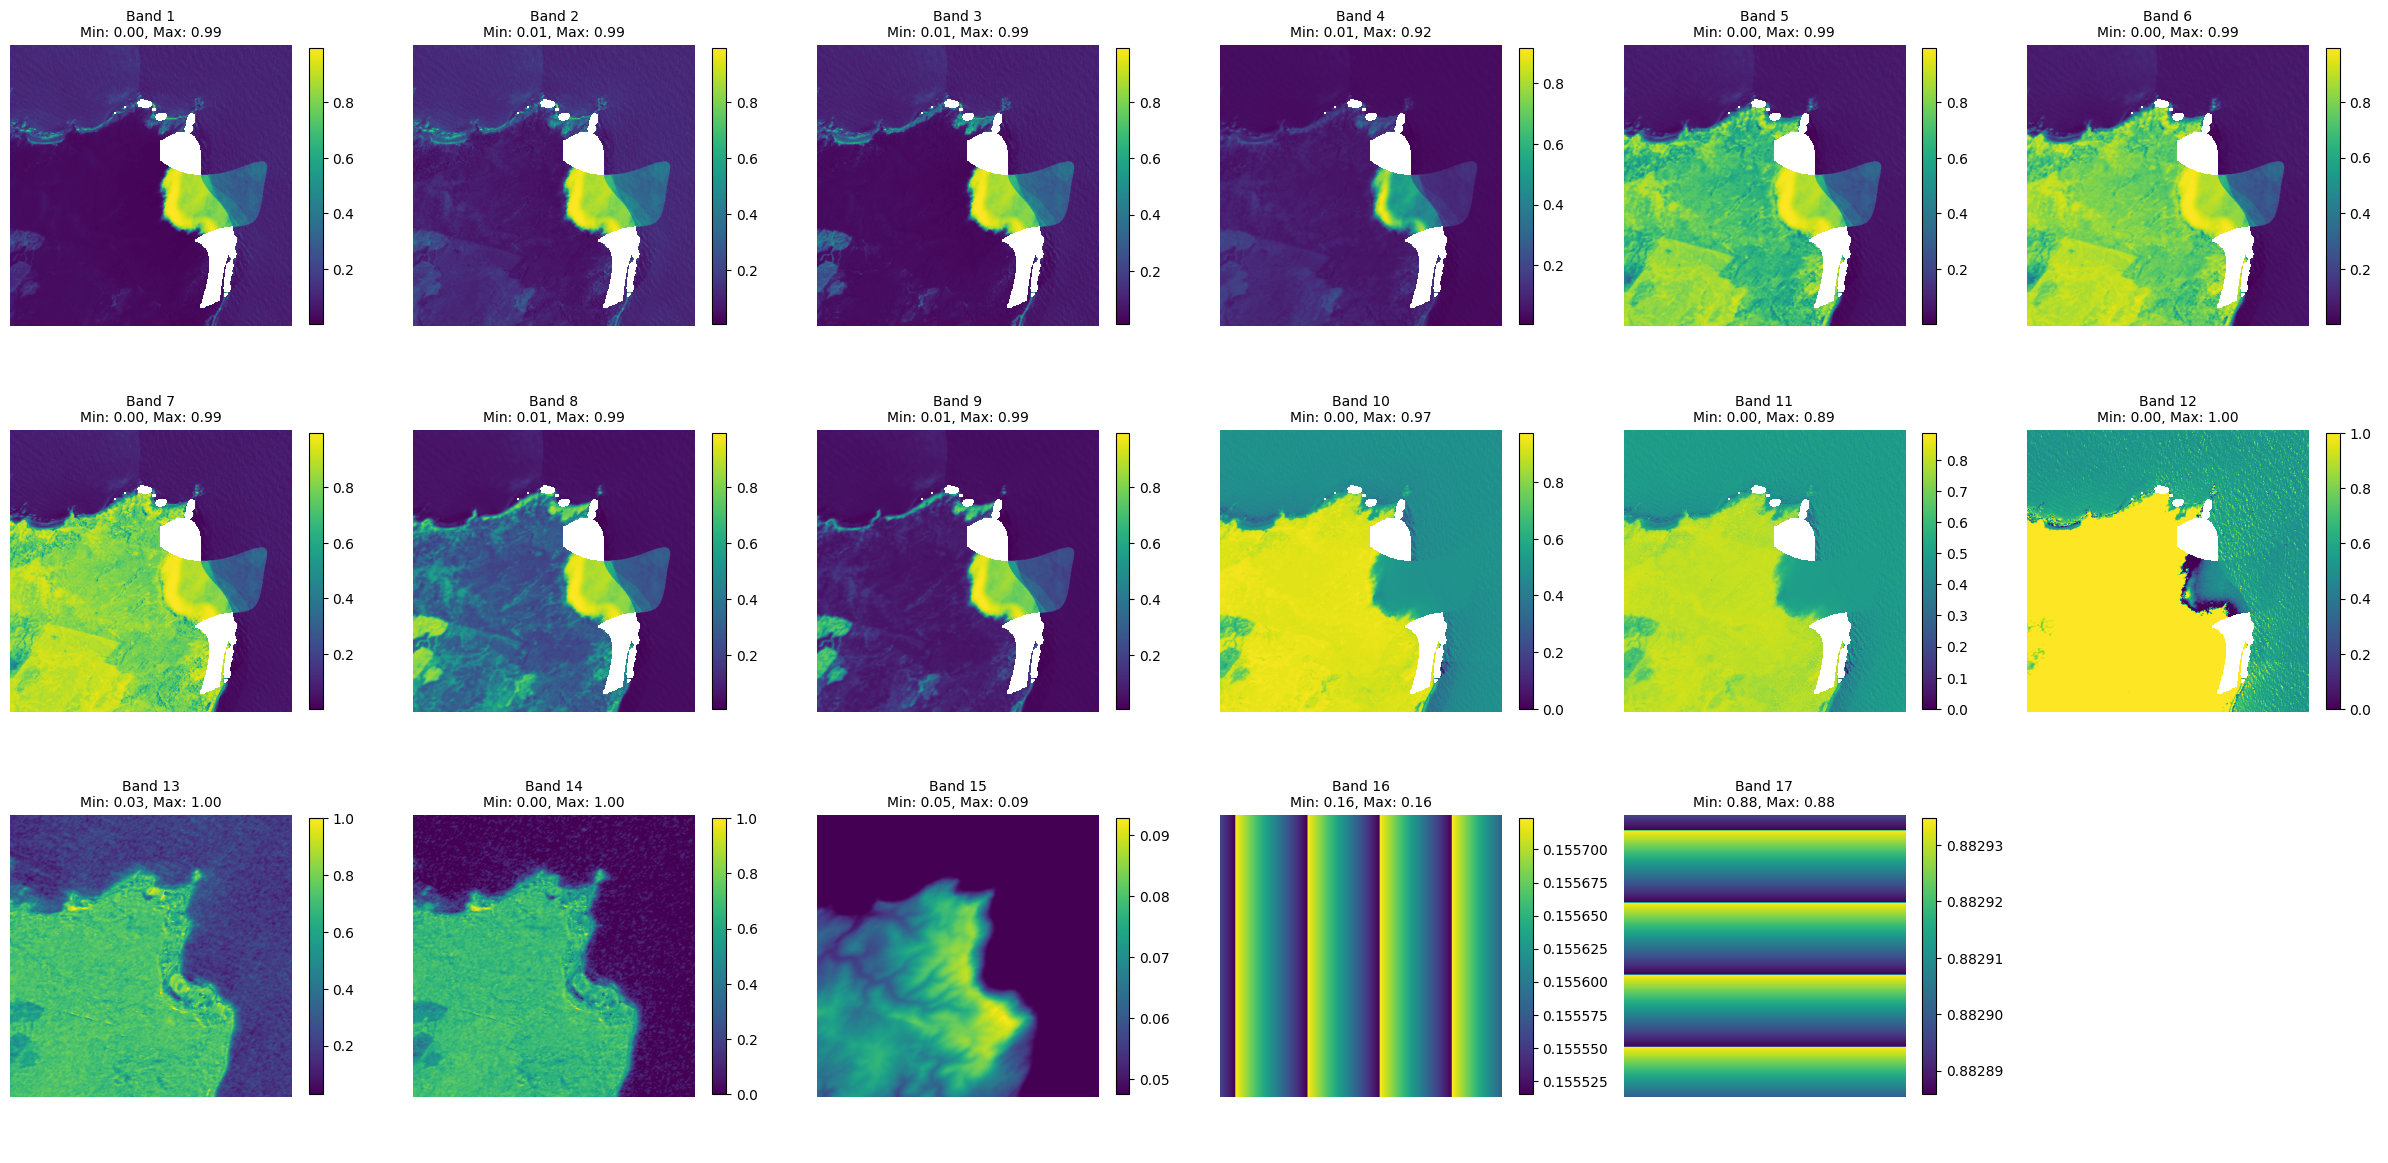

In [34]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import math

# Path to your GeoTIFF
tiff_path = r"C:/Git_projects/WAC/production/prediction/input_testj-2507181257094f7ea5fc7e7f8cb7770a/openEO_2023-06-01Z.tif"

# Open the GeoTIFF
with rasterio.open(tiff_path) as src:
    num_bands = src.count
    print(f"Number of bands: {num_bands}")

    # Set grid size: auto layout
    cols = 6
    rows = math.ceil(num_bands / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    axes = axes.flatten()  # Flatten to easily index

    for i in range(1, num_bands + 1):
        band = src.read(i)
        band_min = np.nanmin(band)
        band_max = np.nanmax(band)

        print(f"Band {i}: min = {band_min}, max = {band_max}")

        ax = axes[i - 1]
        img = ax.imshow(band, cmap='viridis')
        ax.set_title(f'Band {i}\nMin: {band_min:.2f}, Max: {band_max:.2f}', fontsize=10)
        ax.axis('off')
        fig.colorbar(img, ax=ax, shrink=0.7)

    # Turn off unused subplots
    for j in range(num_bands, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

C:\Users\VROMPAYH\AppData\Local\Temp\ipykernel_21568\448969158.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


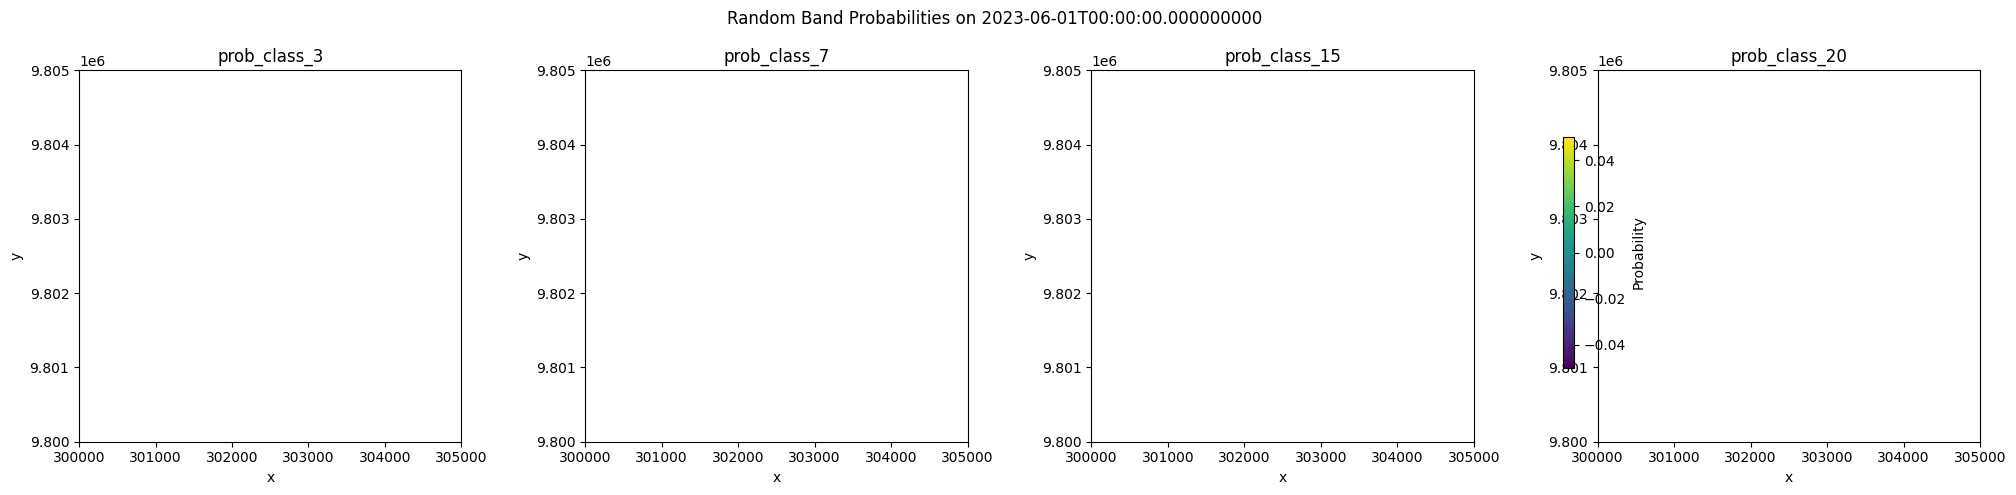

In [ ]:
import matplotlib.pyplot as plt
import xarray as xr
ds = xr.open_dataset("C:/Git_projects/WAC/production/prediction/testj-25071812401340b383e7c9a0c3b74f3c/openEO.nc")





In [28]:
# Get the DataArray for t=0
data = ds['prob_class_0'].isel(t=0)

# Get min and max
data_min = data.min().item()
data_max = data.max().item()

print(f"Range: {data_min} to {data_max}")

Range: nan to nan


In [ ]:
# Hardcoded band names (can be changed)
selected_bands = ['prob_class_3', 'prob_class_7', 'prob_class_15', 'prob_class_20']

# Select time index 0 (corresponds to '2023-06-01')
time_index = 0
time_label = str(ds.t.values[time_index])  # for the plot title

# Plotting
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for i, band in enumerate(selected_bands):
    ax = axes[i]
    img = ds[band].isel(t=time_index).plot.imshow(ax=ax, add_colorbar=False)
    ax.set_title(band)
    ax.set_xlabel('x')
    ax.set_ylabel('y')

# Optional: add a colorbar for one of the plots
cbar = fig.colorbar(img, ax=axes, orientation='vertical', shrink=0.6)
cbar.set_label('Probability')

plt.suptitle(f'Random Band Probabilities on {time_label}')
plt.tight_layout()
plt.show()